In [1]:
import os
import urllib.request
from urllib.request import urlopen as urlopen
import geopandas as gpd
import json
import matplotlib.pylab as plt
import requests
import numpy as np
import pandas as pd
import shapely
import io
from io import BytesIO
from fiona.crs import from_epsg
from geopandas.tools import sjoin

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
os.environ["PUIdata"] = "{}/PUIdata".format(os.getenv("HOME"))

# 1. PUMA : Public Use Microdata Area

### 1.1 Download the NYC Public Use Microdata Areas (PUMA) geometry from the NYC Open Data API and read it in with geopandas

In [3]:
# Clear out any old versions of the NYC spatial data
!if [ -f file.gz ]; then rm -r file.gz; fi
!if [ $PUIDATA/puma ]; then rm -r $PUIDATA/puma; fi

In [4]:
# Download data
urllib.request.urlretrieve('https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?'\
                           + 'method=export&format=Shapefile', "file.gz")

('file.gz', <http.client.HTTPMessage at 0x7f60d9f7d978>)

In [5]:
# Unzip to PUIData
!unzip file.gz -d $PUIdata/puma
!cd $PUIdata/puma

Archive:  file.gz
  inflating: /nfshome/shb395/PUIdata/puma/geo_export_b7f65807-da45-433b-9b97-b4680f684253.dbf  
  inflating: /nfshome/shb395/PUIdata/puma/geo_export_b7f65807-da45-433b-9b97-b4680f684253.shp  
  inflating: /nfshome/shb395/PUIdata/puma/geo_export_b7f65807-da45-433b-9b97-b4680f684253.shx  
  inflating: /nfshome/shb395/PUIdata/puma/geo_export_b7f65807-da45-433b-9b97-b4680f684253.prj  


In [6]:
# Get list of files in file.gz
files = !ls $PUIdata/puma
print(files)

['geo_export_b7f65807-da45-433b-9b97-b4680f684253.dbf', 'geo_export_b7f65807-da45-433b-9b97-b4680f684253.prj', 'geo_export_b7f65807-da45-433b-9b97-b4680f684253.shp', 'geo_export_b7f65807-da45-433b-9b97-b4680f684253.shx']


In [7]:
# Load the shapefile and convert puma column to ints for later merge
shp = files[2]
loc = os.environ["PUIdata"] + '/puma/' + shp
pumashp = gpd.GeoDataFrame.from_file(loc)
pumashp['puma'] = pumashp['puma'].astype('int')
pumashp.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


### 1.2 plot the PUMA NYC regions

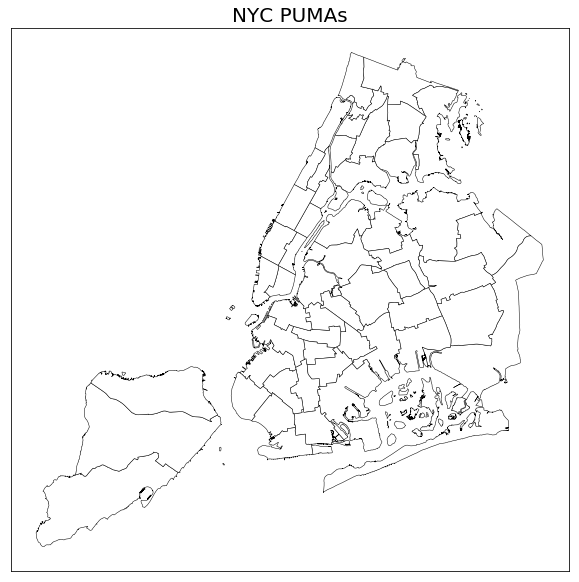

In [8]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
pumashp.plot(alpha=1,linewidth=0.5,ax=ax,color='w',edgecolor='black')
plt.title("NYC PUMAs", fontsize=20)
plt.show()

## Note on above plot:

This is a plot of every Public Use Microdata Area (PUMA) in NYC. PUMAs are statistical geographic areas defined for the dissemination of Public Use Microdata Sample (PUMS) data. PUMAs have a minimum population of 100,000, are aggregated from census tracts, and approximate Community Districts (CDs), or combinations of CDs. This geography is also used for disseminating American Community Survey (ACS) estimates.

# 2. American Fact Finder data on percentage of houses with broadband internet access

### 2.1 Get data with American Fact Finder (AFF) API:

In [9]:
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [10]:
affkeys = np.array(list(aff1y['variables'].keys()))

In [11]:
print(affkeys)

['B11004_004E' 'B08526_072E' 'B24122_366E' ..., 'B23003_012E'
 'B17001G_059E' 'B12002G_013E']


In [12]:
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription')]

In [13]:
# Keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [14]:
# Keyword for the number of households with broadband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

In [15]:
# Getting total number of households
url = 'http://api.census.gov/data/2016/acs/acs1?get=B28002_001E,NAME&for=public%20use%20microdata%20area:*&in=state:36&key='
"""
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds + \
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key="
"""
resp = requests.request('GET', url).content
print(resp)
pumaHH = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaHH

b'[["B28002_001E","NAME","state","public use microdata area"],\n["40479","St. Lawrence County PUMA, New York","36","00100"],\n["67092","Clinton, Franklin, Essex & Hamilton Counties PUMA; New York","36","00200"],\n["51614","Warren & Washington Counties PUMA, New York","36","00300"],\n["44300","Herkimer (North & Central) & Oneida (Outer) Counties PUMA, New York","36","00401"],\n["61146","Oneida County (Central)--Greater Utica & Rome Cities PUMA, New York","36","00402"],\n["42081","Otsego, Schoharie, Oneida (South) & Herkimer (South) Counties PUMA; New York","36","00403"],\n["50860","Jefferson & Lewis Counties PUMA, New York","36","00500"],\n["44633","Oswego County PUMA, New York","36","00600"],\n["56295","Onondaga County (Central)--Syracuse City PUMA, New York","36","00701"],\n["47988","Onondaga County (North) PUMA, New York","36","00702"],\n["65650","Onondaga County (Central)--Syracuse City (Outer) PUMA, New York","36","00703"],\n["44017","Cayuga & Onondaga (South) Counties PUMA, New Yo

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN
5,42081,"Otsego, Schoharie, Oneida (South) & Herkimer (...",36,403,NaN
6,50860,"Jefferson & Lewis Counties PUMA, New York",36,500,NaN
7,44633,"Oswego County PUMA, New York",36,600,NaN
8,56295,"Onondaga County (Central)--Syracuse City PUMA,...",36,701,NaN
9,47988,"Onondaga County (North) PUMA, New York",36,702,NaN


In [16]:
# Getting number of households with broadband access
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB + \
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key="
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [17]:
pumaHH.rename(columns={'public use microdata area':'puma'}, inplace=True)
pumaBB.rename(columns={'public use microdata area':'puma'}, inplace=True)

### 2.2 Generate a feature for the percentage of households with broadband access

In [18]:
merged = pd.merge(pumaHH,pumaBB[['puma','B28002_004E']],on='puma', how='left')
merged.head(5)

,B28002_001E,NAME,state,puma,Unnamed: 4,B28002_004E
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN,32607
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,50811
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN,41210
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,36075
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,47786


In [19]:
merged['pcBB'] = merged['B28002_004E']/merged['B28002_001E']*100

In [20]:
merged.head(5)

,B28002_001E,NAME,state,puma,Unnamed: 4,B28002_004E,pcBB
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN,32607,80.552879
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,50811,75.733321
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN,41210,79.842678
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,36075,81.433409
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,47786,78.150656


### 2.3 Now compare it with the AFF published "percentage of households with broadband access."

In [21]:
# Unzip and load file downloaded directly from Census website
!if [ $PUIDATA/ACS_16 ] ; then echo "Yes"; else unzip ACS_16_1YR_GCT2801.ST50.zip -d $PUIdata/ACS_16; fi

Yes


In [22]:
GCT2801 = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16/ACS_16_1YR_GCT2801.ST50.csv",\
                       usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])

In [23]:
GCT2801.head(5)

,GCT_STUB.target-geo-id2,HC01,HC02
0,Target Geo Id2,Percent,Margin of Error
1,36,81.7,0.2
2,3600100,80.6,2.6
3,3600200,75.7,2.2
4,3600300,79.8,2.6


In [24]:
# Rename GID column for ease of use
GCT2801.rename(columns = {'GCT_STUB.target-geo-id2':'gid'}, inplace=True)

In [25]:
# Drop first row and cast first column as int
GCT2801.drop(0, inplace=True)
GCT2801['gid'] = GCT2801['gid'].astype('int')

In [26]:
GCT2801.head(5)

,gid,HC01,HC02
1,36,81.7,0.2
2,3600100,80.6,2.6
3,3600200,75.7,2.2
4,3600300,79.8,2.6
5,3600401,81.4,2.4


In [27]:
# Perform subtraction on GIDs so data can be merged with PUMA
GCT2801['gid'] = GCT2801['gid'] - 3600000

In [28]:
GCT2801.head(5)

,gid,HC01,HC02
1,-3599964,81.7,0.2
2,100,80.6,2.6
3,200,75.7,2.2
4,300,79.8,2.6
5,401,81.4,2.4


In [29]:
diff_ = merged.merge(GCT2801, right_on="gid", 
                     left_on="puma")[["pcBB", "HC01"]]

diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"].astype(float))
diff_.head(5)

,pcBB,HC01,diff
0,80.552879,80.6,0.047121
1,75.733321,75.7,0.033321
2,79.842678,79.8,0.042678
3,81.433409,81.4,0.033409
4,78.150656,78.2,0.049344


In [30]:
# Check max difference
diff_.describe()

,pcBB,diff
count,145.000000,145.000000
mean,81.845478,0.026217
std,7.063369,0.014480
min,54.932945,0.000178
25%,77.770257,0.012252
50%,82.826141,0.027230
75%,87.305077,0.039090
max,93.404143,0.049872


# 3. Plot a choropleth of NYC broadband access 

### 3.1 Merge with the PUMA geodataframe and plot a choropleth of the percentage of households with broadband access

In [31]:
# Merge pumashp with broadband % data
pumashpmerge = pumashp.merge(merged[['puma','pcBB']],on='puma', how='inner')
pumashpmerge.head(5)

,puma,shape_area,shape_leng,geometry,pcBB
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,84.275820
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",68.310015
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,82.826141
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",72.553737
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,78.778618


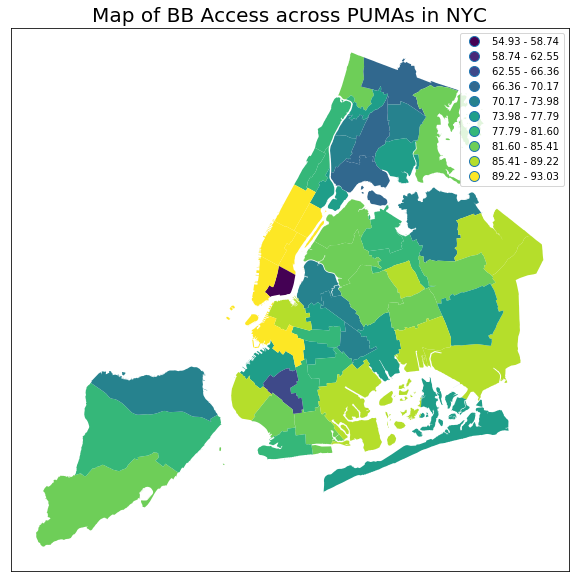

In [32]:
# Plot chloropleth of merged data
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
pumashpmerge.plot(column='pcBB',alpha=1,linewidth=0.5,ax=ax,label='pcBB',scheme="Equal_interval",k=10, legend=True)
plt.title("Map of BB Access across PUMAs in NYC",fontsize=20)
plt.show()


### Note on above plot:

The above plot shows the percentage of households per PUMA that have broadband internet service. PUMAs with the highest concentration of households with broadband access are highlighted in lighter colors while those with lower concentrations are colored in darker shades. 

The plot shows that the highest concentrations of households with broadband are mostly located in Manhattan. Parts of Brooklyn and the Bronx have some of the lowest levels.

# 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

In [33]:
# Create linkNYC df
linkNYC = pd.read_csv("linkNYClocations.csv")
linkNYC.head(5)

,Unnamed: 0,link_site,longitude,date_link_,latitude
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [34]:
linkNYC.shape

(1414, 5)

In [35]:
# Drop first column since it is unnecessary
linkNYC.drop(linkNYC.columns[0], axis=1, inplace=True)
linkNYC.head(5)

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [36]:
linkNYC.shape

(1414, 4)

In [37]:
linkNYC['lonlat'] = list(zip(linkNYC.longitude, linkNYC.latitude))
linkNYC['geometry'] = linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linkNYC.head(5)

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [38]:
linkNYC = gpd.GeoDataFrame(linkNYC)
linkNYC.head(5)

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [39]:
linkNYC.crs = from_epsg(4326)
linkNYC.crs

{'init': 'epsg:4326', 'no_defs': True}

In [40]:
pumashpmerge.head(5)

,puma,shape_area,shape_leng,geometry,pcBB
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,84.275820
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",68.310015
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,82.826141
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",72.553737
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,78.778618


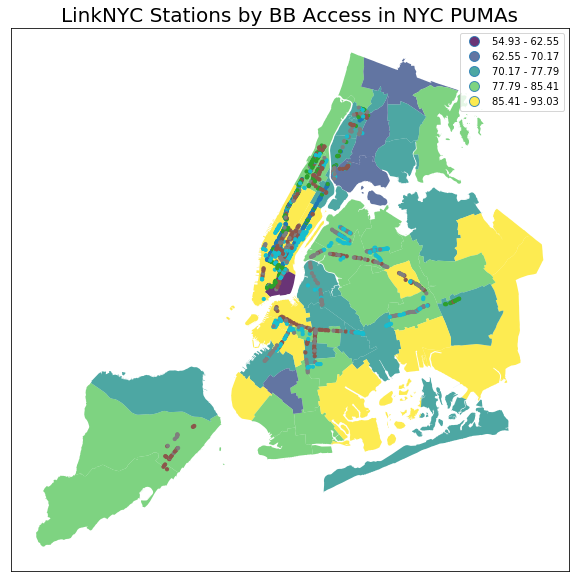

In [41]:
# Plot chloropleth of merged data
f, ax = plt.subplots(figsize=(10,10))
pumashpmerge.plot(column='pcBB',alpha=.8,linewidth=0.5,ax=ax,scheme="Equal_interval",k=5, legend=True)
linkNYC.plot(column='date_link_',alpha=1,ax=ax,scheme="Equal_interval",k=5,s=10)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("LinkNYC Stations by BB Access in NYC PUMAs",fontsize=20)
plt.show()

### Note on above plot:

The above plot shows the percentage of households per PUMA that have broadband internet service. PUMAs with the highest concentration of households with broadband access are highlighted in lighter colors while those with lower concentrations are colored in darker shades. The locations of LinkNYC stations have been plotted as points on top of the map of broadband access per PUMA.

The distribution of LinkNYC stations does not appear to follow a particular pattern of broadband access within NYC.

# 5 Find the number of linkNYC locations per person by PUMA

### 5.1 With the AFF API from ACS, get the total population by PUMA and merge it into your GeoDF

In [42]:
# Get total population per PUMA
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B00001_001E")]
keyTotpop = 'B00001_001E'
aff1y['variables'][keyTotpop]

{'attributes': 'B00001_001EA',
 'concept': 'UNWEIGHTED SAMPLE COUNT OF THE POPULATION',
 'group': 'B00001',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [43]:
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyTotpop + \
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key="
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaPop.rename(columns={'public use microdata area':'puma'}, inplace=True)

In [44]:
pumaPop.head(5)

,B00001_001E,NAME,state,puma,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [45]:
pumashp.head(5)

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [46]:
# Merge population data with PUMA geometry data
pumaPopGeo = pd.merge(pumashp, pumaPop[['B00001_001E','puma']],on='puma', how='inner')
pumaPopGeo.head(5)

,puma,shape_area,shape_leng,geometry,B00001_001E
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,1517
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",1959
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,1305
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",1882
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,2515


In [47]:
# Convert merged pumashp and linkNYC to 2263 crs
pumaPopGeo2263 = pumaPopGeo.to_crs(epsg=2263)
linkNYC2263 = linkNYC.to_crs(epsg=2263)

In [48]:
print(type(linkNYC))
print(type(pumaPopGeo2263))

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>


In [49]:
# Spatial join
linkpp = gpd.sjoin(pumaPopGeo2263,linkNYC2263).groupby('puma')['link_site'].agg(np.size).reset_index(name='link_site')
linkpp.rename(columns={'link_site':'total_sites'}, inplace=True)
linkpp.head(5)

,puma,total_sites
0,3701,1
1,3705,1
2,3706,20
3,3707,29
4,3708,19


### 5.2 Find the number of LinkNYC stations per 100 people per PUMA

In [50]:
# LinkNYC per 100 inhabitants
finalpumashp = pd.merge(pumaPopGeo,linkpp[['puma','total_sites']],on='puma', how='inner')
finalpumashp["linkNYCp100p"] = finalpumashp['total_sites']/(finalpumashp['B00001_001E']/100)
finalpumashp["linkNYCp100p"].describe()

count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%       0.538358
50%       1.299590
75%       1.873385
max      15.141540
Name: linkNYCp100p, dtype: float64

In [51]:
print(type(finalpumashp))

<class 'geopandas.geodataframe.GeoDataFrame'>


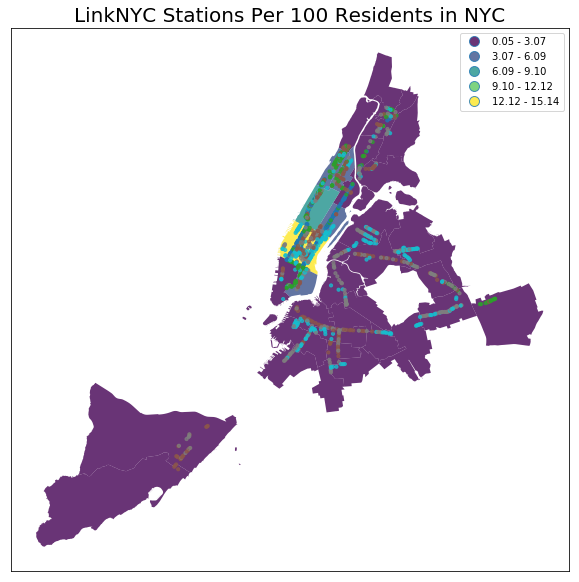

In [52]:
# Plot chloropleth of linkNYC stations per 100 inhabitants of each PUMA
f, ax = plt.subplots(figsize=(10,10))
finalpumashp.plot(column='linkNYCp100p',alpha=.8,linewidth=0.5,ax=ax,label='pcBB',scheme="Equal_interval",k=5, legend=True)
linkNYC.plot(column='date_link_',alpha=.75,ax=ax,scheme="Equal_interval",k=5,s=10)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("LinkNYC Stations Per 100 Residents in NYC", fontsize=20)
plt.show()

### Note on above plot:

The above plot shows the number of LinkNYC stations for every 100 people living within each PUMA in NYC. PUMAs with the highest concentration of LinkNYC stations per 100 residents are highlighted in lighter colors while those with lower concentrations are colored in darker shades. The locations of individual LinkNYC stations have also been plotted as points.

The plot shows that the PUMAs with the most LinkNYC stations per 100 residents are located primarily in Manhattan (excluding the southwest tip of Manhattan).